#### Jupyter notebook to compute shear across ERA5 ensemble for Nepartak forcing data.

James Ruppert  
jruppert@ou.edu  
6/15/25

With support from ChatGPT

#### Main Settings

In [1]:
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
from read_wrf_functions import *
import xarray as xr
from tropycal import tracks

In [2]:
# Write pickle files out for shear?
do_readwrite = True
# do_readwrite = False

#### Directories and grib files
datdir = "/glade/campaign/univ/uokl0049/nepartak/"
file_tag="mem*/grib/ERA*-pl*grib"

# Get grib file ensemble
grib_files = get_wrf_file_list(datdir, file_tag)
nmemb = len(grib_files)
# grib_files

# General regional subset to work with smaller dataset
latmin, latmax, lonmin, lonmax = -4, 33.0, 110.0, 156.0

# Get times
grib_file = xr.open_mfdataset(grib_files[0], engine="cfgrib", combine='by_coords')
grib_file = grib_file.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
grib_times = grib_file.time.values.astype('datetime64[m]')
# Create 2D mesh of lat-lon points
lat = grib_file['latitude']
lon = grib_file['longitude']
lon2d, lat2d = np.meshgrid(lon, lat)
grib_file.close()

nt_grib = len(grib_times)

In [3]:
# # Print some metadata
# ds_plevs = xr.open_mfdataset(grib_files[0], combine='by_coords', engine="cfgrib", filter_by_keys={'typeOfLevel': 'isobaricInhPa'})

# for ds in [ds_plevs]:
#     for ivar in ds.data_vars:
#         print(ivar)
#         print(ds[ivar].attrs['standard_name'])
#         print(ds[ivar].attrs['long_name'])
#         print(ds[ivar].dims)
#         print(ds[ivar].units)
#         print(ds[ivar].shape)
#         print()

### Read and process data

#### Read in observed storm track

In [5]:
# Read in basin only if it hasn't been yet
if 'basin' not in locals():
    basin = tracks.TrackDataset(basin='west_pacific',source='ibtracs')
storm = basin.get_storm(('nepartak',2016))
tc_track = {
    'vmax': storm.vars['vmax'],
    'mslp': storm.vars['mslp'],
    'lon': storm.vars['lon'],
    'lat': storm.vars['lat'],
    'time': np.array(storm.vars['time'], dtype='datetime64[m]'),
    # 'lon': storm.vars['wmo_lon'],
    # 'lat': storm.vars['wmo_lat'],
    }

In [6]:
# Interpolate observed TC track to GRIB data times

valid_times = []
vmax = []
pres = []
ilon = []
ilat = []
for it in range(nt_grib):
    # Skip if the time is not in the TC track
    if grib_times[it] < np.min(tc_track['time']) or grib_times[it] > np.max(tc_track['time']):
        continue
    # print(f"Interpolating TC track for time {grib_times[it]}")
    valid_times.append(grib_times[it])
    vmax.append(np.interp(grib_times[it].astype(float), tc_track['time'].astype(float), tc_track['vmax']))
    pres.append(np.interp(grib_times[it].astype(float), tc_track['time'].astype(float), tc_track['mslp']))
    ilon.append(np.interp(grib_times[it].astype(float), tc_track['time'].astype(float), tc_track['lon']))
    ilat.append(np.interp(grib_times[it].astype(float), tc_track['time'].astype(float), tc_track['lat']))

# Convert lists to numpy arrays
tc_track_gribtimes = {
    'time': np.array(valid_times, dtype='datetime64[m]'),
    'vmax': np.array(vmax),
    'mslp': np.array(pres),
    'lon': np.array(ilon),
    'lat': np.array(ilat),
}

nt_interp = len(tc_track_gribtimes['time'])

#### Run ERA5 processing for testing

In [7]:
# # Get list of surface files
# file_tag="mem*/grib/ERA*-sl*grib"
# # Get grib file ensemble
# sfc_grib_files = get_wrf_file_list(datdir, file_tag)
# sfc_grib_files[0]

In [8]:
# # Parameters for shear calculation
# plevs_shear=(850,200)
# radius_min_km = 200 # Maximum distance from TC center to compute shear
# radius_max_km = 800

# # Compute great-circle distance from each grid point to center point
# def compute_distance_grid(lat_grid, lon_grid, center_lat, center_lon):
#     flat_lat = lat_grid.ravel()
#     flat_lon = lon_grid.ravel()
#     distances = np.array([
#         distance((center_lat, center_lon), (la, lo)).km
#         for la, lo in zip(flat_lat, flat_lon)
#     ])
#     return distances.reshape(lat_grid.shape)

# # mean_shear_ens = []

# # for imember, grib_file in enumerate(tqdm_notebook(grib_files[:2])):

# ds = xr.open_mfdataset(grib_files[0], engine="cfgrib", combine='by_coords',
#                        filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
# # ds = xr.open_mfdataset(sfc_grib_files[0], combine='by_coords', engine="cfgrib",
# #                            filter_by_keys={'typeOfLevel': 'surface'})
# ds = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# itime=3

# u_itime = ds.u.sel(time=tc_track_gribtimes['time'][itime])
# v_itime = ds.v.sel(time=tc_track_gribtimes['time'][itime])

# # Get shear
# u850 = u_itime.sel(isobaricInhPa=plevs_shear[0])
# v850 = v_itime.sel(isobaricInhPa=plevs_shear[0])
# u200 = u_itime.sel(isobaricInhPa=plevs_shear[1])
# v200 = v_itime.sel(isobaricInhPa=plevs_shear[1])
# # ushear = u200 - u850
# # vshear = v200 - v850
# # shear = np.sqrt(ushear**2 + vshear**2)

# # shear = ds.u.sel(isobaricInhPa=plevs_shear[0])

# # shear_plot = shear.sel(time=tc_track_gribtimes['time'][itime], method='nearest')

# # # for itime in range(nt_interp):
# # for itime in range(30,31):

#     # Get the center point of the TC track at this time
# lat_center = tc_track_gribtimes['lat'][itime]
# lon_center = tc_track_gribtimes['lon'][itime]

#     # Compute distance grid from center point
# distance_grid = compute_distance_grid(lat2d, lon2d, lat_center, lon_center)
#     # Mask the shear for current time step to annulus
# # shear_plot = shear_plot.where(
# #     ((distance_grid <= radius_max_km)))
#     # ((distance_grid >= radius_min_km) & (distance_grid <= radius_max_km)))
# u850_masked = u850.where(
#     ((distance_grid <= radius_max_km)))
# v850_masked = v850.where(
#     ((distance_grid <= radius_max_km)))
# u200_masked = u200.where(
#     ((distance_grid <= radius_max_km)))
# v200_masked = v200.where(
#     ((distance_grid <= radius_max_km)))
# u850_mean = u850_masked.mean(skipna=True)
# v850_mean = v850_masked.mean(skipna=True)
# u200_mean = u200_masked.mean(skipna=True)
# v200_mean = v200_masked.mean(skipna=True)
# ushear = u200_mean - u850_mean
# vshear = v200_mean - v850_mean
# shear = np.sqrt(ushear**2 + vshear**2)

In [9]:
# # Plot a map of shear at a specific time
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import numpy as np

# # Specific time index (if shear is time-dependent, select the appropriate slice)
# # shear = shear[time_index, :, :]  # Uncomment if shear has a time dimension

# # Create the map
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

# # Plot the shear data
# plot_object = ax.pcolormesh(lon, lat, shear,
#                            transform=ccrs.PlateCarree(), cmap='viridis', shading='nearest')

# # Add map features
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.set_title('Shear Map at Specific Time')

# # Add a colorbar
# cbar = plt.colorbar(plot_object, ax=ax, orientation='horizontal', pad=0.05)
# cbar.set_label('Shear (units)')

# # Show the plot
# plt.show()

#### Read in ERA5 shear

In [11]:
# Read in processed data
mean_shear = np.zeros((nmemb, nt_interp))
for imemb in range(nmemb):
    fileout = "nepartak_shear_imemb_" + str(imemb) + ".nc"
    ds = xr.open_dataset(fileout)
    mean_shear_imemb = ds.mean_shear.values
    mean_shear[imemb, :] = np.squeeze(mean_shear_imemb)
    ds.close()

# Write to combined netCDF file
ds_all = xr.open_mfdataset("nepartak_shear_imemb_*.nc")
ds_all.to_netcdf("nepartak_shear_era5.nc")
ds_all.close()

---
### Plotting routines

##### Plot functions

In [12]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}

rc('font', **font)

sns.set_theme(style="white", rc={'xtick.bottom': True, 'ytick.left': True, "axes.spines.right": False, "axes.spines.top": False})

#### Create plots

In [13]:
# Get all times up to first time when vmax >= 64 kts
vmax_thresh = 64.0
t1_avg = np.where(tc_track_gribtimes['vmax'] >= vmax_thresh)[0][0]-1
avg_times = np.arange(0, t1_avg+1)
# print(avg_times)
# print(tc_track_gribtimes['time'][avg_times])
# print(tc_track_gribtimes['time'])

NameError: name 'tc_track_gribtimes' is not defined

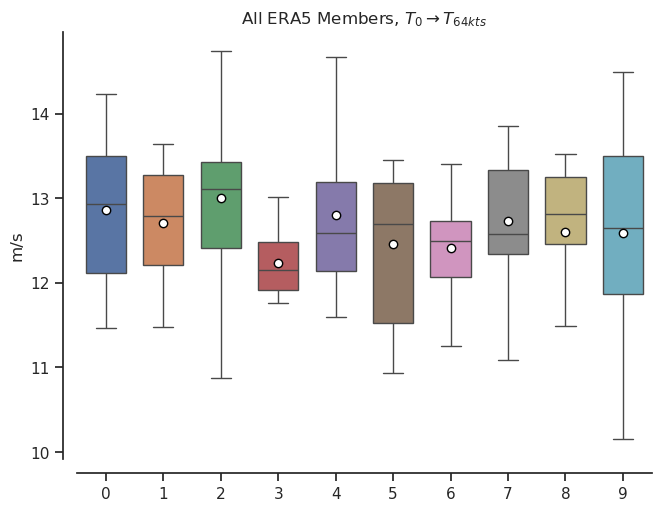

In [ ]:
# Plot all ensemble members

fig, ax = plt.subplots(1,1, figsize=(6.5,5), layout="constrained",)

# sns.boxplot([mean_shear[im,:] for im in range(nmemb)],
sns.boxplot([mean_shear[im,avg_times] for im in range(nmemb)],
            width=0.7, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", 
            "markeredgecolor":"black", "markersize":"6"},
            showfliers=False,)

# ax.set_ylim([1e-2,1e14])
sns.despine(offset=10,ax=ax)
plt.ylabel('m/s')
plt.title(r'All ERA5 Members, $T_0\rightarrow T_{64kts}$')
plt.show()

<Axes: >

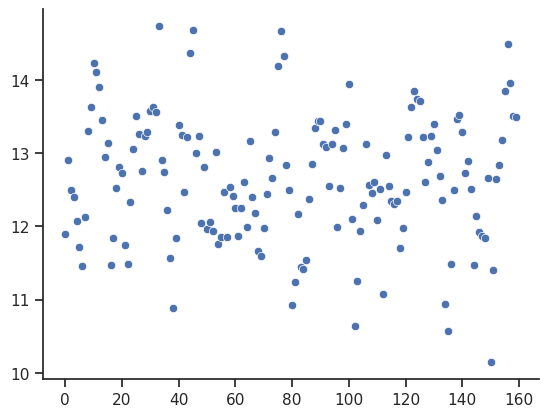

In [ ]:
sns.scatterplot(mean_shear[:,avg_times].flatten())